# Auto-rounding explanation

Let's consider a step function $f$ over integer in $[x_{min}, x_{max}]$.

In [1]:
from concrete.ml.common.preprocessors import TLUDeltaBasedOptimizer, InsertRounding
from concrete import fhe
import numpy as np
import matplotlib.pyplot as plt
from concrete.fhe import Configuration, Integer

# Doesn't work for constant yet
# Constant function
# input_range = (-234, 283)
# def f(x):
#     x = x.astype(np.float64)
#     x = 0.75 * x - 200
#     x = x * (x > 0)
#     x = x // 118
#     # x = (x + 2.1) / 3.4
#     x = np.rint(x)
#     x = x.astype(np.int64)
#     return x

# Doesn't work for constant yet
# # 1 jump
# input_range = (-234, 283)
# def f(x):
#     x = x.astype(np.float64)
#     x = 0.75 * x + 0.
#     x = x * (x > 0)
#     x = x // 118
#     # x = (x + 2.1) / 3.4
#     x = np.rint(x)
#     x = x.astype(np.int64)
#     return x

# # Works for this function
# 2 jumps -> like what we have in CIFAR
input_range = (-256, 256)
def f(x):
    x = x.astype(np.float64)
    x = 0.6 * x + 134.
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x
    
# # Works for this function!
# # 5 jumps
# input_range = (-234, 283)
# def f(x):
#     x = x.astype(np.float64)
#     x = 0.93 * x + 163.  # 75  80
#     x = x * (x > 0)
#     x = x // 69
#     # x = (x + 2.1) / 3.4
#     x = np.rint(x)
#     x = x.astype(np.int64)
#     return x

In [2]:
inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)

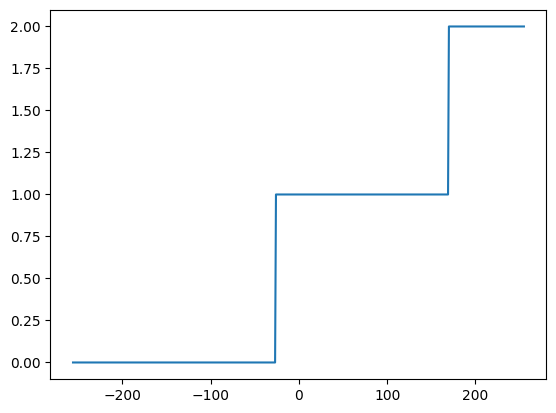

In [3]:
y = f(inputset)
plt.plot(inputset, y)

We can compute all thresholds $t_i$ and corresponding thresholds $\delta_{i}$ s.t. $\delta_i = t_{i+1} - t_{i}$

In [4]:
change_mask = np.concatenate([[False], np.diff(y).astype(bool)])
thresholds = inputset[change_mask]
deltas = np.diff(thresholds)
thresholds, deltas

(array([-26, 170]), array([196]))

We consider $n_{orig}$ the bit-width required to represent the input of the function.

In [5]:
input_repr = Integer.that_can_represent(inputset)
input_repr.bit_width

9

The bit-width required to properly represent the function with rounding can be expressed as a function of $x_{min}, x_{max}, \delta$ for each $\delta_i$.

In [6]:
msbs_to_keep_set = set()
for delta in deltas:
    msbs_to_keep = np.ceil(np.log2(np.ceil((inputset.max() - inputset.min()) / delta))).astype(np.int64)
    msbs_to_keep_set.add(msbs_to_keep)
msbs_to_keep_set

{2}

In [7]:
assert len(msbs_to_keep_set) == 1
msbs_to_keep

2

Should we do something like the $gcd(\{\delta_i\}_{i})$? Or assume that $\delta_i = \delta \forall i$ but in practice $\delta_i = \delta (\pm(1,0)) \forall i$

Just rounding to keep `msbs_to_keep` is not enough.

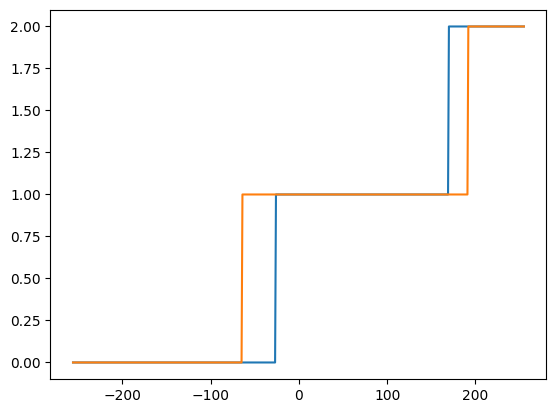

In [8]:
x_with_raw_rounding = fhe.round_bit_pattern(inputset, lsbs_to_remove=int(input_repr.bit_width - msbs_to_keep))
y_with_raw_rounding = f(x_with_raw_rounding)
plt.plot(inputset, y)
plt.plot(inputset, y_with_raw_rounding)

We can improve things by offsetting before rounding

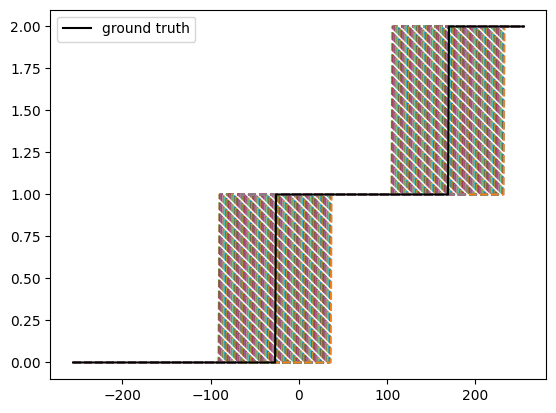

In [9]:
n = 2**(input_repr.bit_width - msbs_to_keep)
diff = np.zeros(n)
for offset in range(n):
    x_with_offset = fhe.round_bit_pattern(inputset - offset, lsbs_to_remove=int(input_repr.bit_width - msbs_to_keep)) + offset
    y_with_offset = f(x_with_offset)
    diff[offset] = (y_with_offset != y).sum()
    plt.plot(inputset, y_with_offset, linestyle="--")

plt.plot(inputset, y, color="black", label="ground truth")
plt.legend()

([<matplotlib.lines.Line2D at 0x31677a3a0>], 0, 60.0)

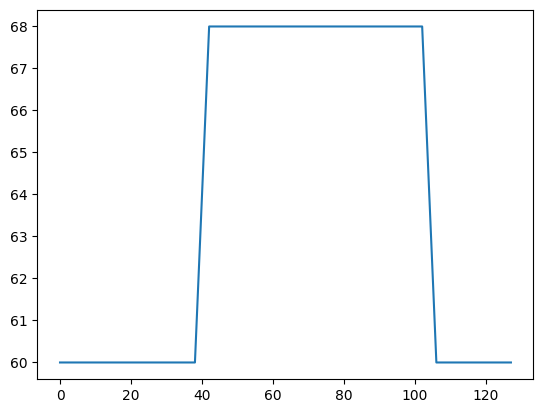

In [10]:
plt.plot(diff), np.argmin(diff), np.min(diff)

In [11]:
np.arange(len(diff))[diff == np.min(diff)]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127])

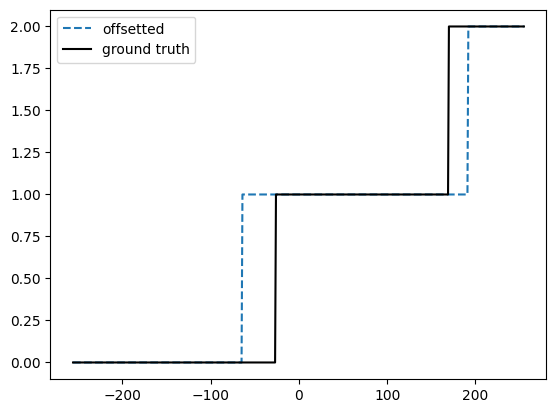

In [12]:
offset = np.arange(len(diff))[diff == np.min(diff)][0]
x_with_offset = fhe.round_bit_pattern(inputset - offset, lsbs_to_remove=int(input_repr.bit_width - msbs_to_keep)) + offset
y_with_offset = f(x_with_offset)
diff[offset] = (y_with_offset != y).sum()
plt.plot(inputset, y_with_offset, linestyle="--", label="offsetted")
plt.plot(inputset, y, color="black", label="ground truth")
plt.legend()

In [13]:
# msbs_to_keep = np.ceil(np.log2(np.ceil((inputset.max() - inputset.min()) / deltas[0]))).astype(np.int64)
# lsbs_to_remove = int(input_repr.bit_width - msbs_to_keep)
# print(f"{lsbs_to_remove=}, {input_repr.bit_width=}, {msbs_to_keep=}")
# print(f"{thresholds=}")
# print(f"{deltas=}")
# offsets_truncation = thresholds % 2**(msbs_to_keep)
# print(f"{offsets_truncation=}")
# offsets_rounding = (2**(lsbs_to_remove-1)) + offsets
# print(f"{offsets_rounding=}")

How about scaling such that $a \delta \approx 2^{m}$ width $m = n_{arbitrary} - n_{msbs-to-keep}$ with $n_{arbitrary} > n_{input}$

In [14]:
target_bit_width = 24

For each $\delta_i$ we can compute a $a_i$ coefficient that does this mapping.

It's given by $$\left \lfloor  \frac{2^{n_a - n_m}}{\delta_i} \right \rfloor $$

TODO: check if floor is the best or we should try with both ceil and floor, or just rint.

In [15]:
from collections import Counter
a_candidates = Counter()
for delta in deltas:
    a_candidate = np.floor(2**(target_bit_width - msbs_to_keep) / delta).astype(np.int64)
    a_candidates[a_candidate]+=1

In [16]:
a_candidates

Counter({21399: 1})

In [17]:
a = a_candidates.most_common(1)[0][0]
a

21399

In [18]:
multiplied_input_repr = Integer.that_can_represent((inputset * a))
assert multiplied_input_repr.bit_width == target_bit_width
multiplied_input_repr.bit_width

24

We can see that now our steps are almost perfectly of the correct size but there is still a slight offset to correct.

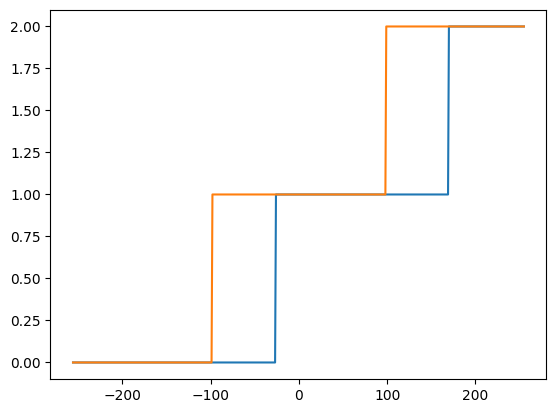

In [19]:
scaled_inputset = inputset*a
lsbs = Integer.that_can_represent(scaled_inputset).bit_width-msbs_to_keep
x_with_offset = fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)) / a
y_with_offset = f(x_with_offset)
plt.plot(inputset, y)
plt.plot(inputset, y_with_offset)

Now let's add the offsetting.

In [20]:
from tqdm import tqdm

diff = []
bs = list(range(0, 2**(lsbs-1)-1, a))

for b in tqdm(bs):
    scaled_inputset = inputset*a - b
    scaled_bitwidth = Integer.that_can_represent(scaled_inputset).bit_width
    # The following assert breaks if the bounds are [-2^(n-1), 2^(n-1)-1]
    # assert scaled_bitwidth == target_bit_width, f"{scaled_bitwidth=}!={target_bit_width=}"
    lsbs = scaled_bitwidth - msbs_to_keep
    x_with_offset = (fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)) + b) / a
    y_with_offset = f(x_with_offset)
    error = (y_with_offset != y).sum()
    diff.append(error)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 21951.58it/s]


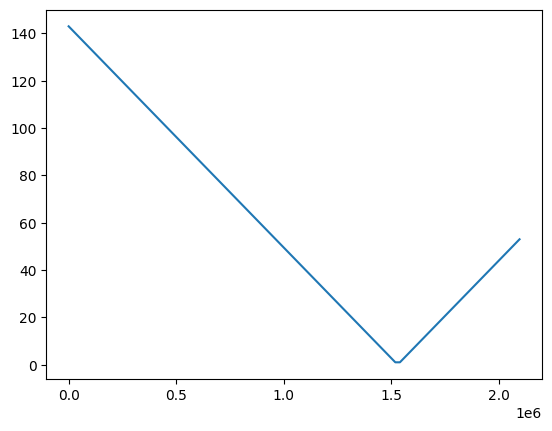

In [21]:
plt.plot(bs, diff)

In [22]:
diff = np.array(diff)
argmin = np.argmin(diff)
bs[argmin], diff[argmin]

(1519329, 1)

1


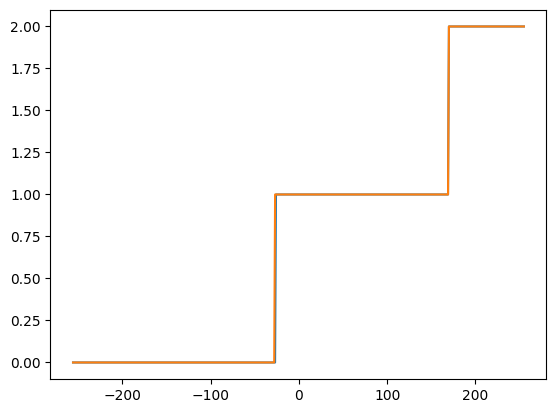

In [23]:
b = bs[argmin]
scaled_inputset = inputset*a - b
lsbs = Integer.that_can_represent(scaled_inputset).bit_width-msbs_to_keep
x_with_offset = (fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)) + b) / a
y_with_offset = f(x_with_offset)
plt.plot(inputset, y)
plt.plot(inputset, y_with_offset)
print((y != y_with_offset).sum())

In [24]:
scaled_bitwidth_ = Integer.that_can_represent(inputset*a).bit_width
lsbs_ = scaled_bitwidth_ - msbs_to_keep
thresholds_ = thresholds*a
b_candidates = fhe.round_bit_pattern(thresholds_, lsbs_to_remove=int(lsbs_)) - thresholds_
b_candidates -= 2**(lsbs_-1)
b_candidates *= -1
b_candidates

array([1540778, 1540678])

In [25]:
b_candidates.max() - b_candidates.min()

100

In [26]:
diff = []
bs = np.arange(b_candidates.min(), b_candidates.max())
for b in tqdm(bs):
    scaled_inputset = inputset*a - b
    lsbs = Integer.that_can_represent(scaled_inputset).bit_width-msbs_to_keep
    x_with_offset = (fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)) + b) / a
    y_with_offset = f(x_with_offset)
    error = (y != y_with_offset).sum()
    diff.append(error)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 19308.13it/s]


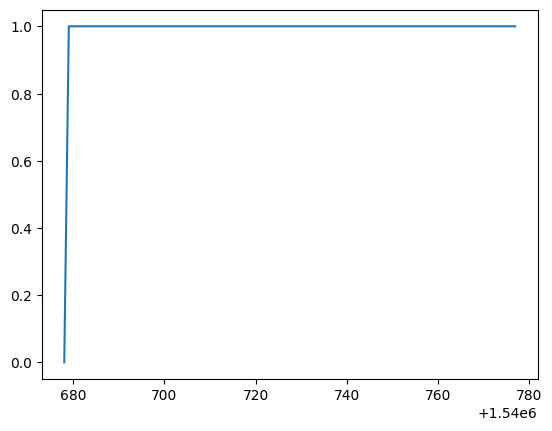

In [27]:
plt.plot(bs, diff)

In [28]:
diff = np.array(diff)
argmin = np.argmin(diff)
bs[argmin], diff[argmin]

(1540678, 0)

0


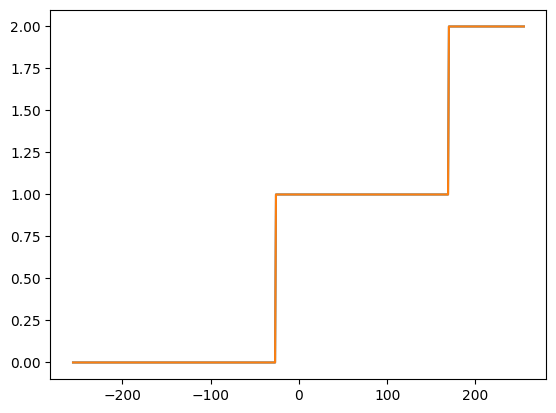

In [29]:
b = bs[argmin]
scaled_inputset = inputset*a - b
lsbs = Integer.that_can_represent(scaled_inputset).bit_width-msbs_to_keep
x_with_offset = (fhe.round_bit_pattern(scaled_inputset, lsbs_to_remove=int(lsbs)) + b) / a
y_with_offset = f(x_with_offset)
plt.plot(inputset, y)
plt.plot(inputset, y_with_offset)
print((y != y_with_offset).sum())